# Vehicle Detection and Tracking

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


In [53]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Histogram of Oriented Gradients (HOG)

Image class defined in model.py provides the following methods and properties for feature extraction:

    - YCrCb, Y, Cr, Cb: Properties returning the image in diferents color spaces  
    - hog(bins=11, ppc=8, cpb=2)  
    - histogram(bins=32)
    - spatial(size=16)
    - features: Property returning the combination of hog, histogram and spatial methods 

------

HOG, histogram and spatial parameters were chosen in order to maximize the accuracy of the classifier on the test dataset


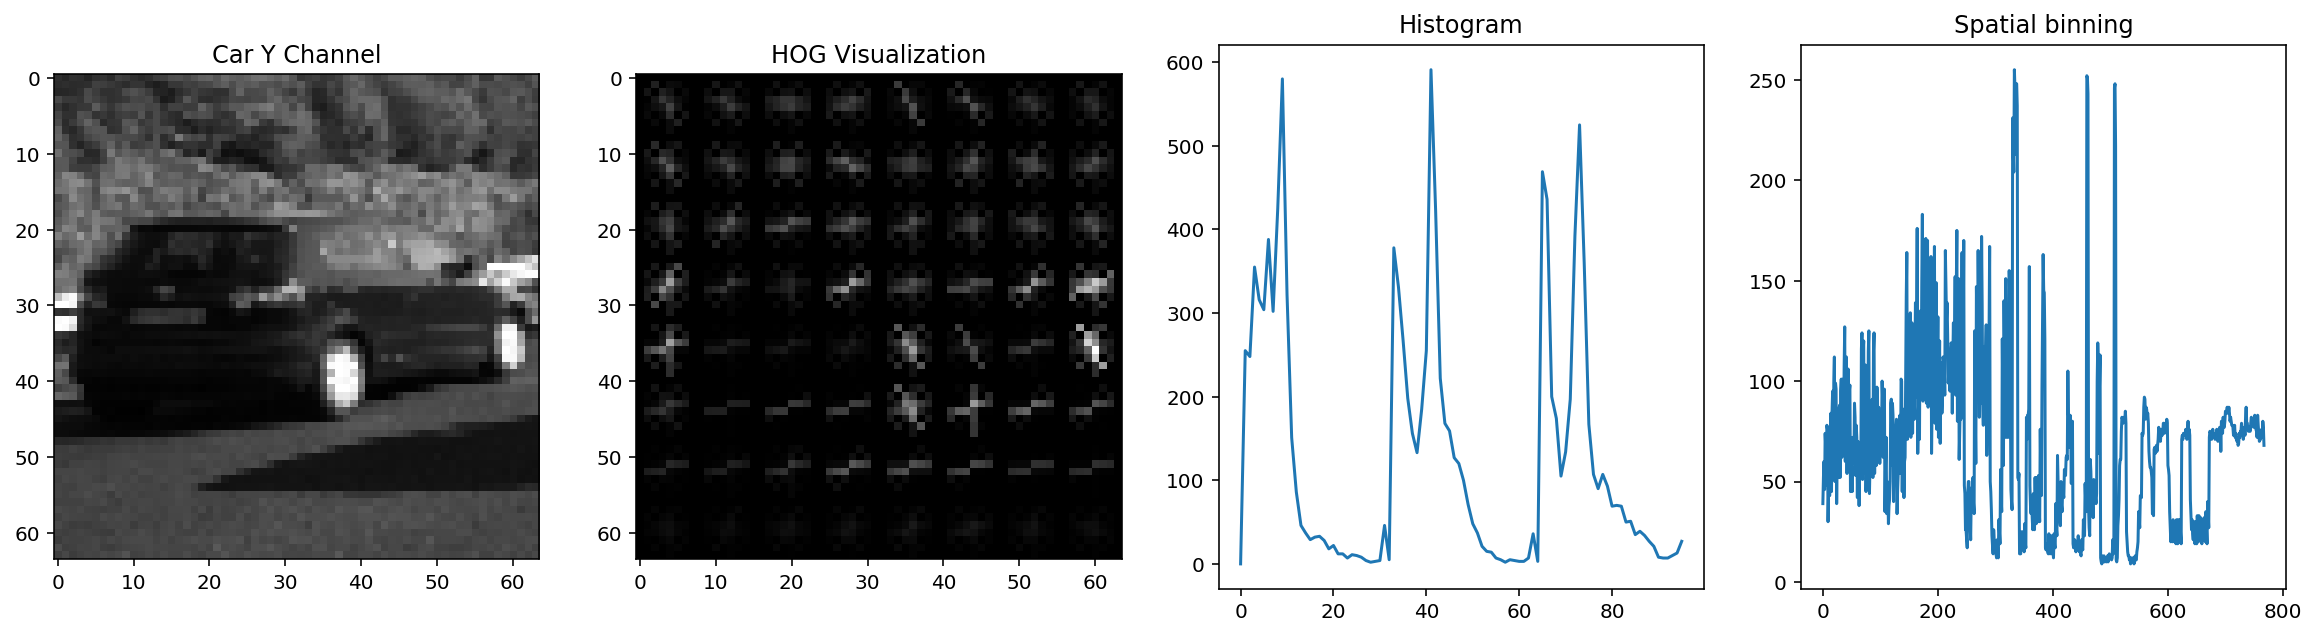

In [54]:
from model import Classifier

classifier = Classifier(limit=100)
image = classifier.image(vehicle=True)

_, hog = image.Y.hog(bins=9, ppc=8, cpb=2, debug=True)
histogram = image.histogram()
spatial = image.spatial()

plt.figure(figsize=(20, 5))
plt.subplot(141)
image.Y.show()
plt.title('Car Y Channel')
plt.subplot(142)
hog.show()
plt.title('HOG Visualization')
plt.subplot(143)
plt.plot(histogram)
plt.title('Histogram')
plt.subplot(144)
plt.plot(spatial)
plt.title('Spatial binning')

### Classifier

Classifier class in model.py encapsulates all the logic related to the classification task. The constructor performs the following tasks:  
    - Load the vehicles and non-vehicles datasets 
    - Balance both datasets to get the same number of samples on each category
    - Normalize the features of each sample
    - Train the SVM classifier
    
Two additional methods were implemented:
    - predict: Normalizes and predicts the category of the input features
    - image: Returns an image from the training dataset
    
The following image Features are used in the classifier:
    - HOG on channels Y, Cr and Cb
    - Histogram on channels R, G and B
    - Spatial binning on RGB channels

In [43]:
from model import Classifier

classifier = Classifier(path='./datasets')
print('Test Accuracy: ', round(classifier.score, 2))


Test Accuracy:  0.98


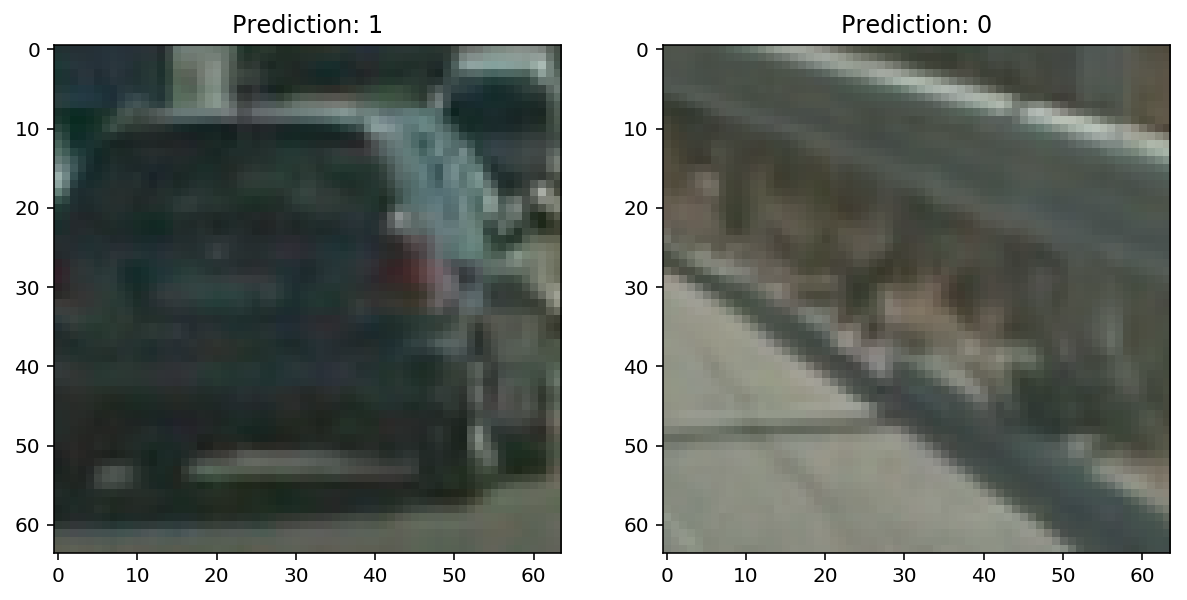

In [52]:
image_v = classifier.image(vehicle=True)
image_nv = classifier.image(vehicle=False)

predict_v = classifier.predict(image_v.features)
predict_nv = classifier.predict(image_nv.features)


fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
image_v.show()
plt.title('Prediction: {}'.format(predict_v))
plt.subplot(122)
image_nv.show()
plt.title('Prediction: {}'.format(predict_nv))


## Sliding Window Search


Image class defined in model.py provides the following methods:

- windows(layers=4, scale_factor=0.2, overlap=0.5): Returns the tiles contained on a grid with the following parameters:
  - layers: Number of layers on the grid (deep) 
  - scale_factor: Ratio between the tiles size of the near and the far layers
  - overlap: Overlap between the tiles on the same layer


- search(classifier, layers=4, scale_factor=0.4, overlap=0.75): Performs a sliding window search using the provided classifier and returning the tiles marked as positive


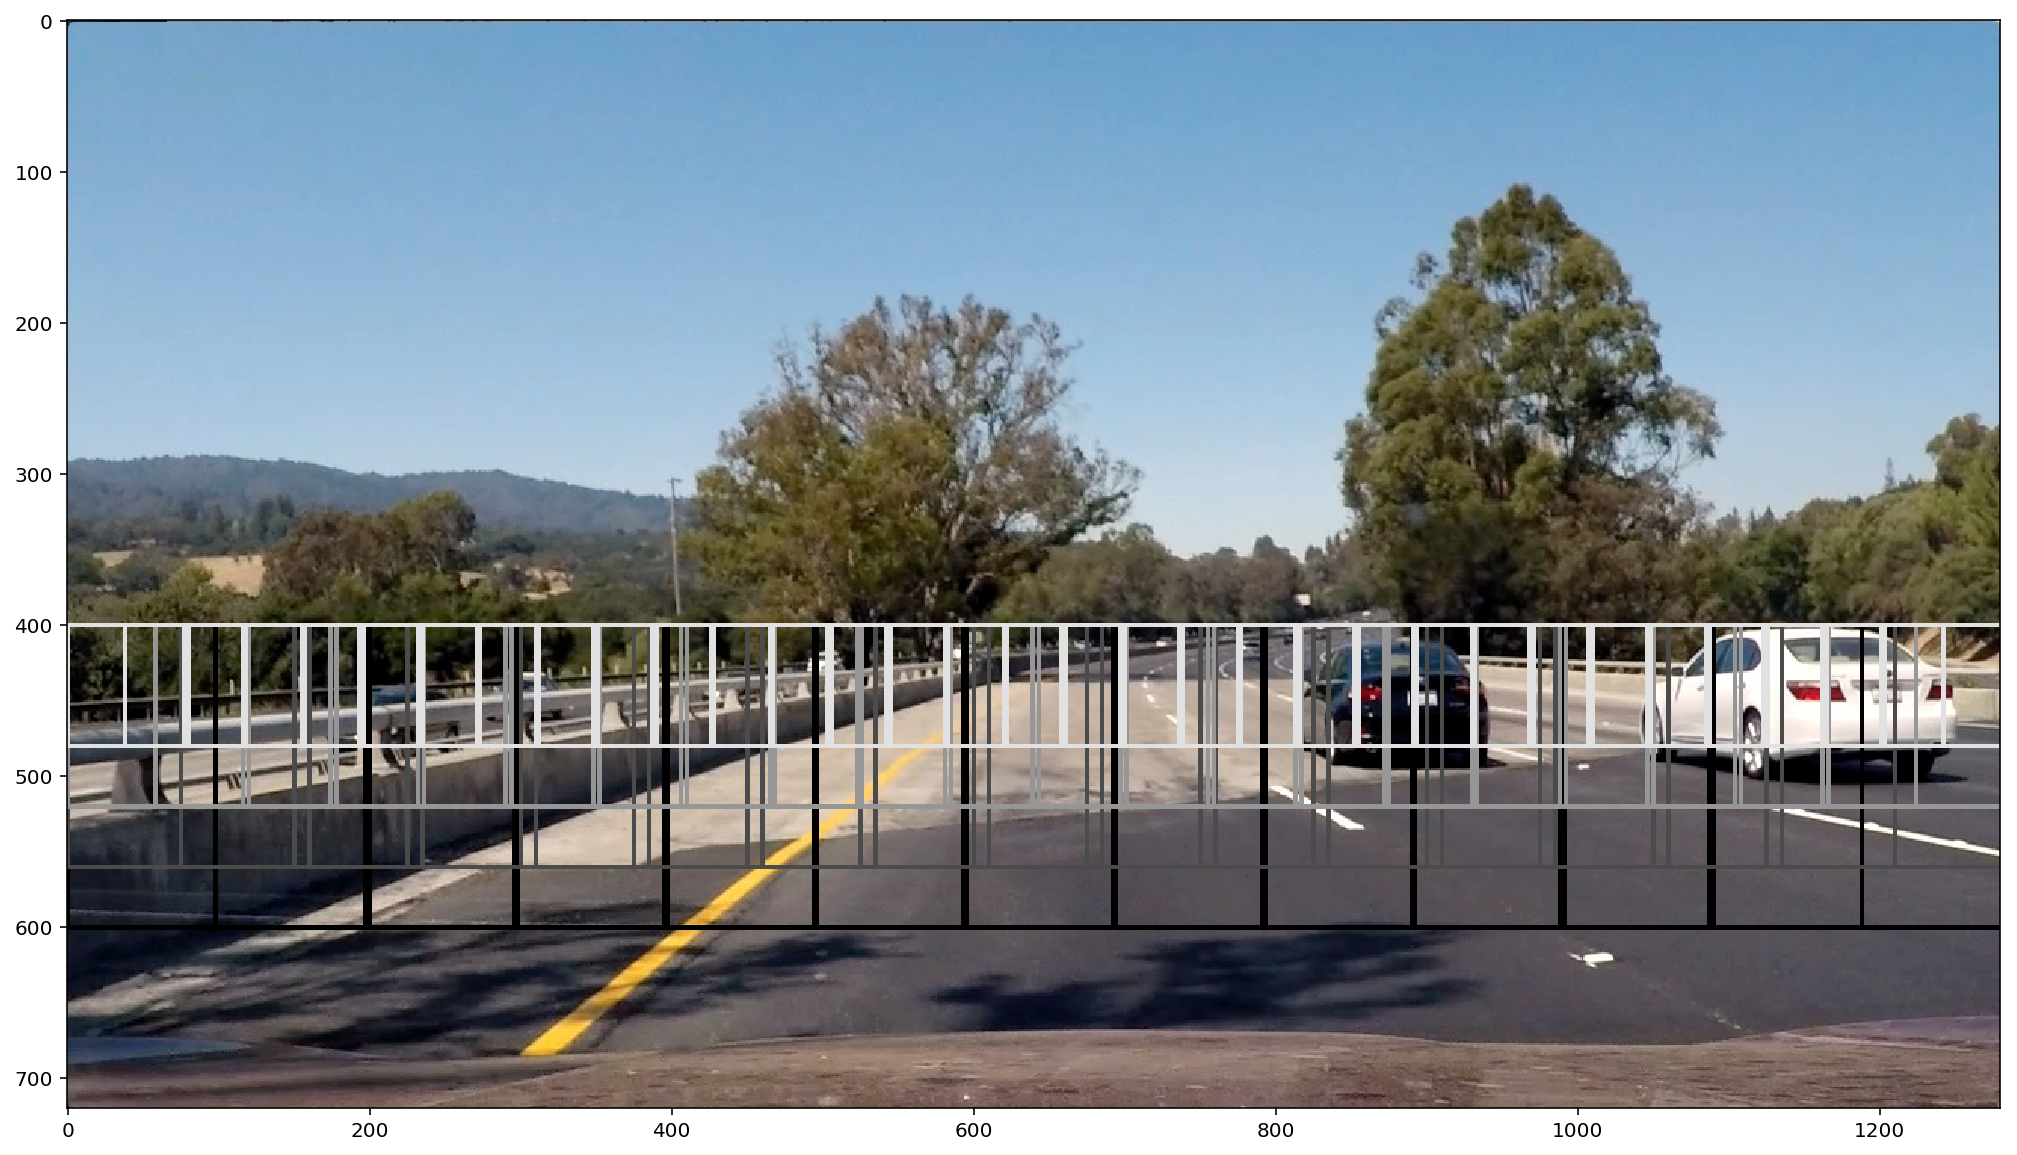

In [37]:
from model import Image

image = Image.imread('test_images/test4.jpg')

for inx, layer in enumerate(image.windows(layers=4, scale_factor=0.4, overlap=0.5)):
    for window in layer:
        image.draw_box(window.metadata['box'], color=(inx * 75, inx * 75, inx*75))    
 
plt.figure(figsize=(20, 10))
image.show() 

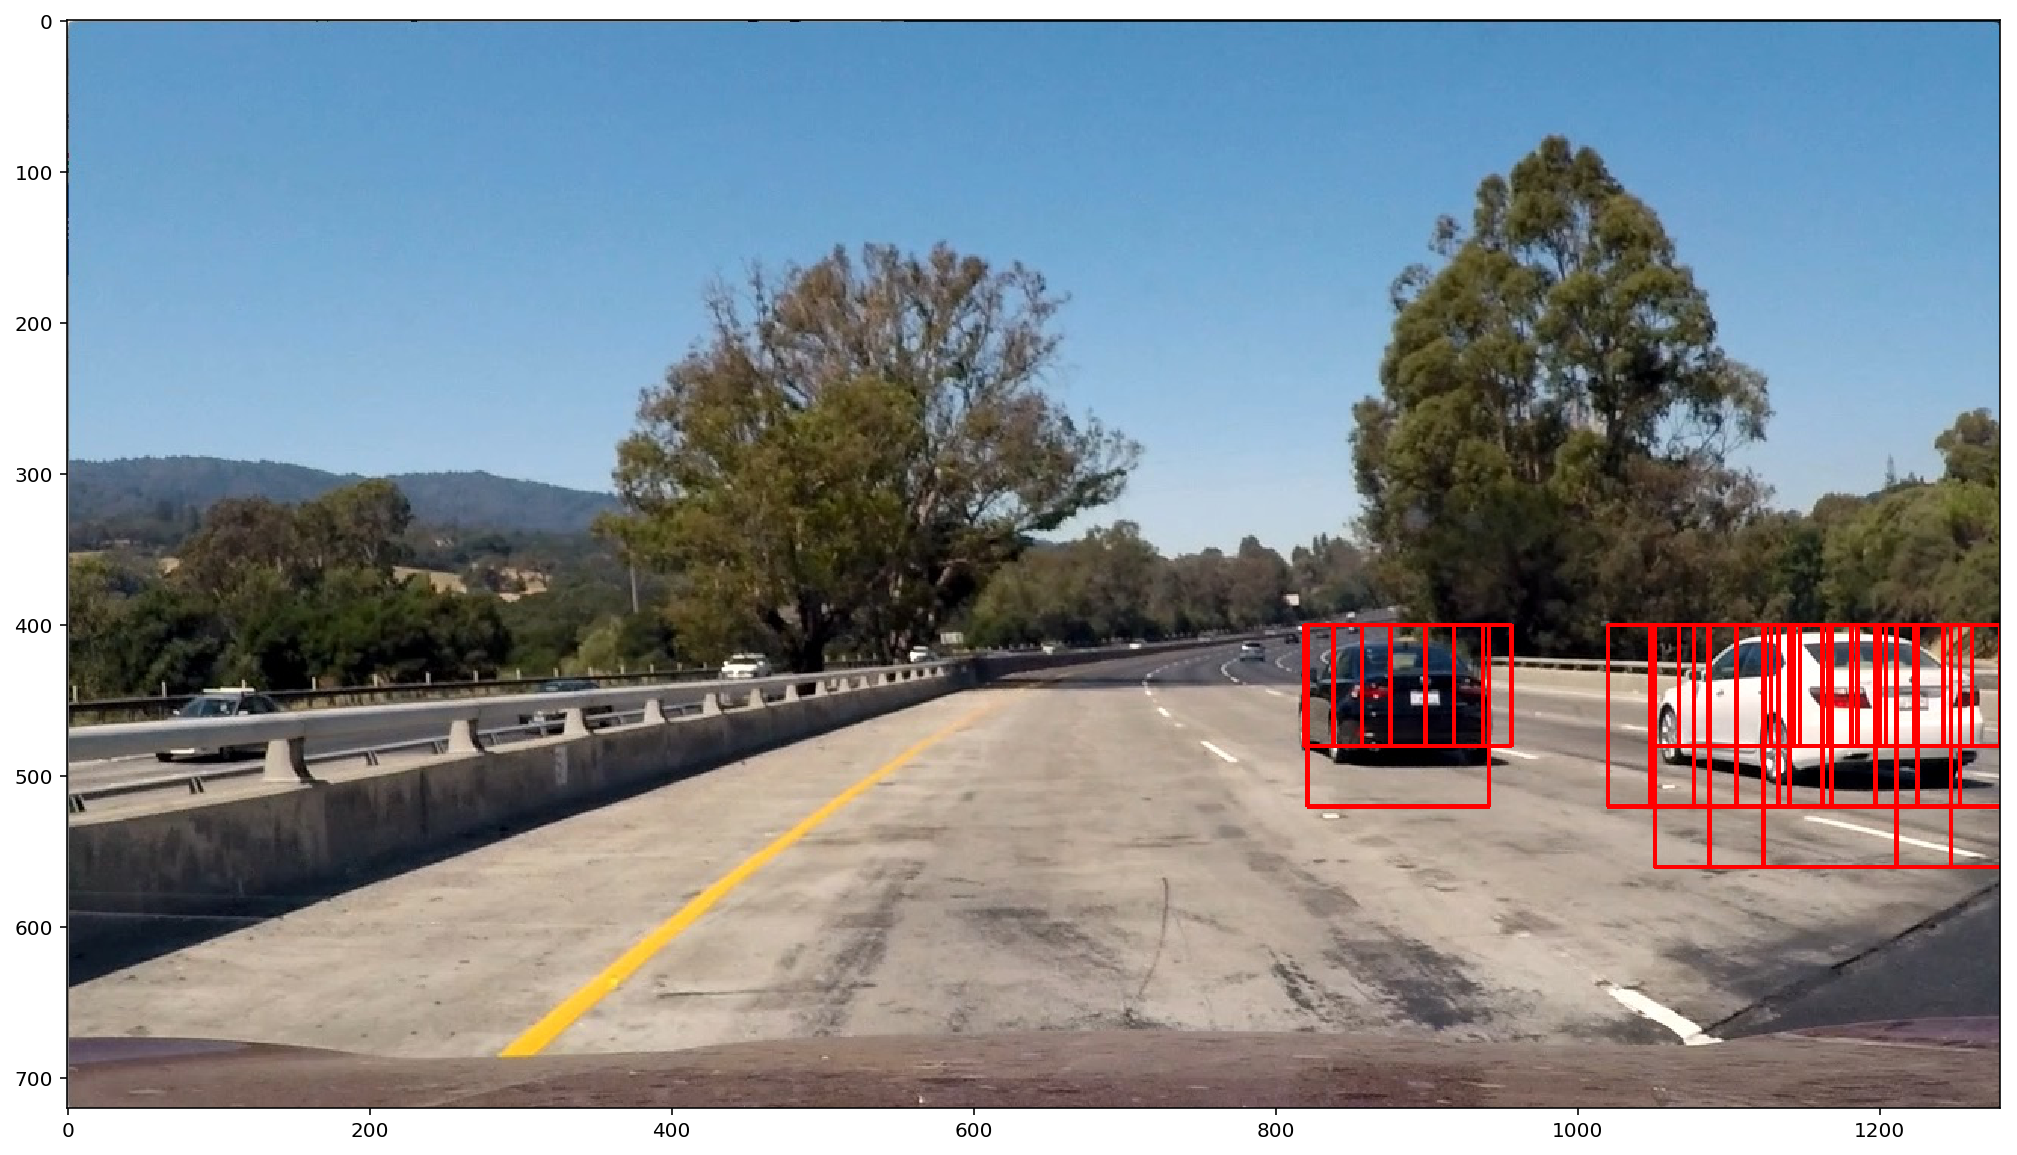

In [47]:
from model import Image

image = Image.imread('test_images/test1.jpg')

for b in image.search(classifier=classifier, layers=4, scale_factor=0.4, overlap=0.75):
    image.draw_box(b)
     
plt.figure(figsize=(20, 10))
image.show()

## Video Implementation


Image class defined in model.py provides the following methods:

- heatmap(results, threshold=2) filter the results returned by the search method removing the areas with less than threshold matches

-------

Tracker class defined in model.py:

 - Tracker(classifier=classifier, layers=8, scale_factor=0.4, overlap=0.75, qsize=12, threshold=24) performs a search on each frame and use qsize number of images to calculate a heatmap with the provied threshold.






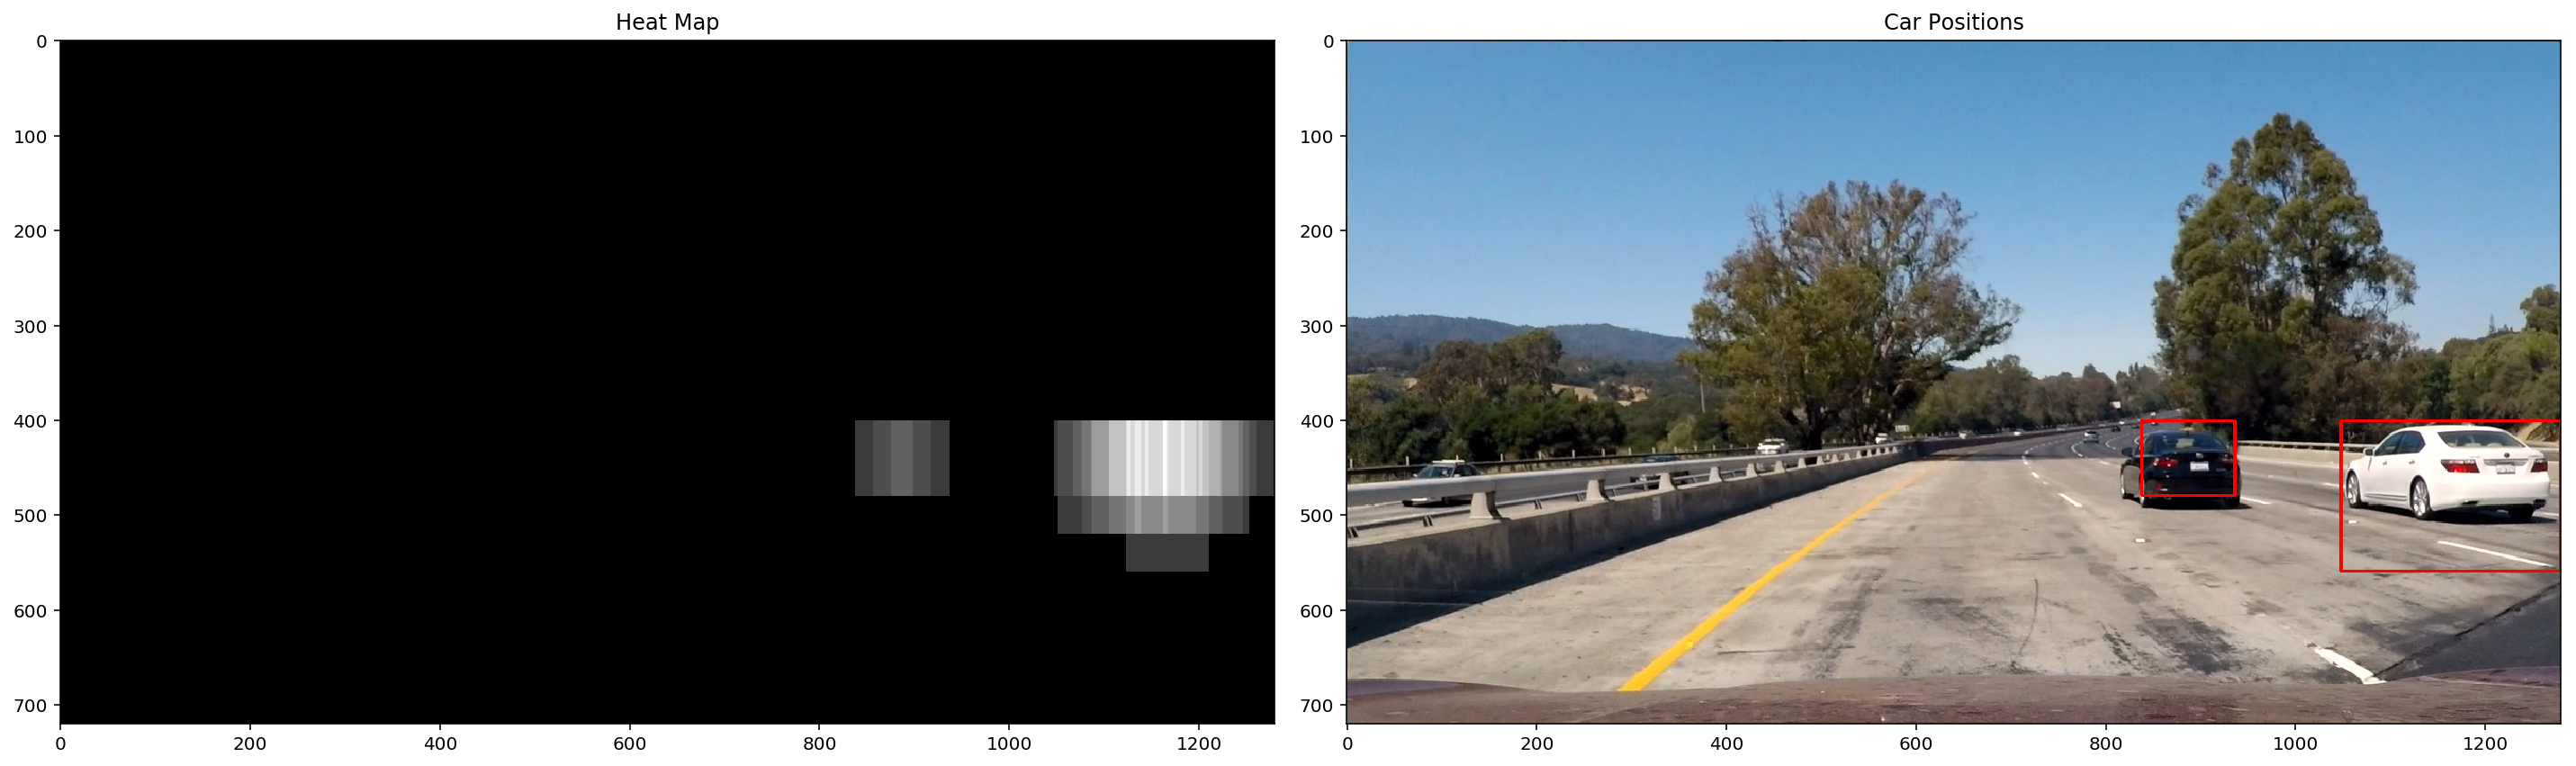

In [50]:
from model import Image

image = Image.imread('test_images/test1.jpg')
results = image.search(classifier=classifier, layers=4, scale_factor=0.4, overlap=0.75)

heatmap = image.heatmap(results, threshold=2)

for box in heatmap.labels():
    image.draw_box(box)
    
fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
heatmap.show(cmap='hot')
plt.title('Heat Map')
plt.subplot(122)
image.show()
plt.title('Car Positions')
fig.tight_layout()

In [36]:
from model import Tracker

from moviepy.editor import VideoFileClip

tracker = Tracker(classifier=classifier,  layers=8, scale_factor=0.4, overlap=0.75, qsize=12, threshold=24) 
def process_image(pixels):
    tracker.run(pixels)
    return tracker.output.RGB.pixels

clip = VideoFileClip('test_video/project_video.mp4')
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile('output_video/project_video.mp4', audio=False)


[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [47:01<00:01,  1.48s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 39min 32s, sys: 1min 9s, total: 40min 42s
Wall time: 47min 3s


# Discussion


Issues:

- Very low performance on video processing 
- High rate of false positives, agressive filtering

Improvements:

- Traking vehicles - centroids
- Predict vehicles position on next frames.
